當前工作目錄： C:\Users\user\Desktop\Python作品集\ETF_Portfolio_Optimization
已儲存 etf_price_clean.csv 與 etf_returns.csv
已儲存 etf_performance.csv


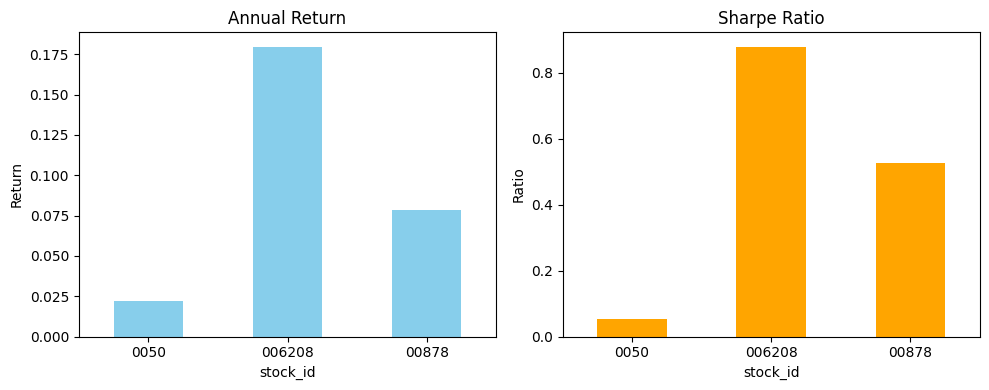

C:\Users\user\AppData\Local\Temp\ipykernel_32520\2154514160.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(max_sharpe_port[1], max_sharpe_port[0], color="red", marker="o", s=100, label="Max Sharpe Ratio")


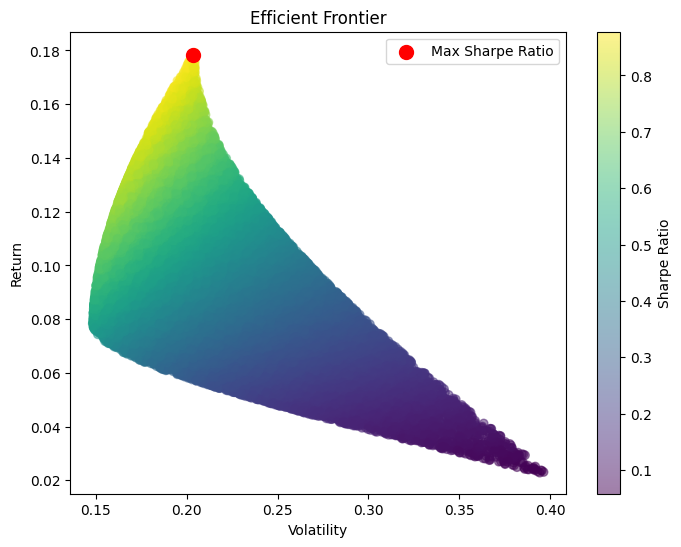

最大夏普比率組合：
Return          0.178487
Volatility      0.203389
Sharpe Ratio    0.877564
0050            0.000040
006208          0.988738
00878           0.011223
Name: 19622, dtype: float64


In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 切換到專案資料夾（依你的實際路徑修改）
os.chdir(r"C:\Users\user\Desktop\Python作品集\ETF_Portfolio_Optimization")
print("當前工作目錄：", os.getcwd())

# 讀取原始價格資料
df = pd.read_csv("data/etf_price_raw.csv", dtype={"stock_id": str})

# 資料轉成寬表格（每個 ETF 為一欄）
df_wide = df.pivot(index="date", columns="stock_id", values="close")

# 日期排序
df_wide = df_wide.sort_index()

# 缺失值處理（用前一天數值填補）
df_wide = df_wide.ffill()

# 計算每日報酬率
df_returns = df_wide.pct_change().dropna()

# 儲存清理後資料
os.makedirs("data", exist_ok=True)
df_wide.to_csv("data/etf_price_clean.csv", encoding="utf-8-sig")
df_returns.to_csv("data/etf_returns.csv", encoding="utf-8-sig")
print("已儲存 etf_price_clean.csv 與 etf_returns.csv")

# ===== 績效計算 =====
trading_days = 252
annual_returns = df_returns.mean() * trading_days
annual_volatility = df_returns.std() * np.sqrt(trading_days)
sharpe_ratio = annual_returns / annual_volatility

performance = pd.DataFrame({
    "Annual Return": annual_returns,
    "Annual Volatility": annual_volatility,
    "Sharpe Ratio": sharpe_ratio
})

performance.to_csv("data/etf_performance.csv", encoding="utf-8-sig")
print("已儲存 etf_performance.csv")

# ===== 圖表 1：績效比較 =====
os.makedirs("visuals", exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

performance["Annual Return"].plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Annual Return")
axes[0].set_ylabel("Return")
axes[0].tick_params(axis='x', rotation=0)

performance["Sharpe Ratio"].plot(kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Sharpe Ratio")
axes[1].set_ylabel("Ratio")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("visuals/performance_chart.png", dpi=300)
plt.show()

# ===== 圖表 2：有效前緣 =====
num_portfolios = 50000
results = np.zeros((3 + len(df_returns.columns), num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(df_returns.columns))
    weights /= np.sum(weights)

    portfolio_return = np.sum(df_returns.mean() * weights) * trading_days
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(df_returns.cov() * trading_days, weights)))
    sharpe = portfolio_return / portfolio_volatility

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe
    for j in range(len(weights)):
        results[j + 3, i] = weights[j]

results_df = pd.DataFrame(results.T, columns=["Return", "Volatility", "Sharpe Ratio"] + list(df_returns.columns))
max_sharpe_port = results_df.iloc[results_df["Sharpe Ratio"].idxmax()]

plt.figure(figsize=(8, 6))
plt.scatter(results_df["Volatility"], results_df["Return"], c=results_df["Sharpe Ratio"], cmap="viridis", alpha=0.5)
plt.colorbar(label="Sharpe Ratio")
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], color="red", marker="o", s=100, label="Max Sharpe Ratio")
plt.title("Efficient Frontier")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.legend()
plt.savefig("visuals/efficient_frontier.png", dpi=300)
plt.show()

print("最大夏普比率組合：")
print(max_sharpe_port)
